In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

keys = ['采集时间', '水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数','氨氮', '总磷', '总氮']
en_keys = ['WaterTemperature', 'PH' ,'dissolved oxygen', 'Conductivity','Turbidity','PermanganateIndex',
        'AmmoniaNitrogen','TP','TN', 'humidity','room temperature','chlorophyll','Algae density']
limits = [(5, 30), (5.0, 9), (1, 15), (50, 500), (0, 1500), (0, 15), (0, 0.5), (0, 0.3), (0, 5)]
np.set_printoptions(formatter = {'float': '{:.2e}'.format})

In [52]:
def cutoff(df, label, limit):
    vals = df[label].values.copy()
    series = pd.Series(vals)
    idxs = (series < limit[0]) | (series > limit[1])
    return idxs

def myfillna(df, window=30):
    for k in df.keys():
        vals = df[k].values.copy()
        N = len(vals)
        step = window // 2
        for i in range(N):
            if np.isnan(vals[i]):
                if i < step:
                    vals[i] = np.mean(vals[:window])
                elif i+step > N:
                    vals[i] = np.mean(vals[-window:])
                else:
                    vals[i] = np.mean(vals[i-step:i+step])
        df.loc[:, k] = vals
    return df

def remove_outliers(df, method):
    for k in df.keys():
        vals = df[k].values.copy()
        outlier_idx = method(df, k)
        vals[outlier_idx] = None
        df.loc[:, k] = vals
    return df

def smooth(df, size=60):
    for k in df.keys():
        vals = df[k].values.copy()
        smooth_vals = pd.Series(vals).ewm(size).mean().values    
        df.loc[:, k] = smooth_vals
    return df

In [53]:
df = pd.read_excel('./original_data.xls', header=2, usecols=keys)
df = df.loc[::-1].reset_index(drop=True)
df.drop(range(178), inplace=True)
df[df.columns[0]] = pd.to_datetime(arg=df[df.keys()[0]], format='%Y-%m-%d %H:%M:%S')
df.set_index(df.columns[0], inplace=True)
df.replace(to_replace= '--', value = None, inplace=True)
df = df.astype('float64')
df = df.abs()

# Remove the outliers
for k in df.keys():
    vals = df[k].values.copy()
    idxs = detect_outlier(df, k, 25)
    vals[idxs] = None
    df.loc[:, k] = vals
    
# Fill nan by interpolate
df = df.interpolate(limit_area='outside', limit_direction='both', method='cubic')

#  Denoise
df = smooth(df, 60)

# Rescale
df = (df - df.min()) / (df.max() - df.min())

Index(['水温', 'pH', '溶解氧', '电导率', '浊度', '高锰酸盐指数', '氨氮', '总磷', '总氮'], dtype='object')


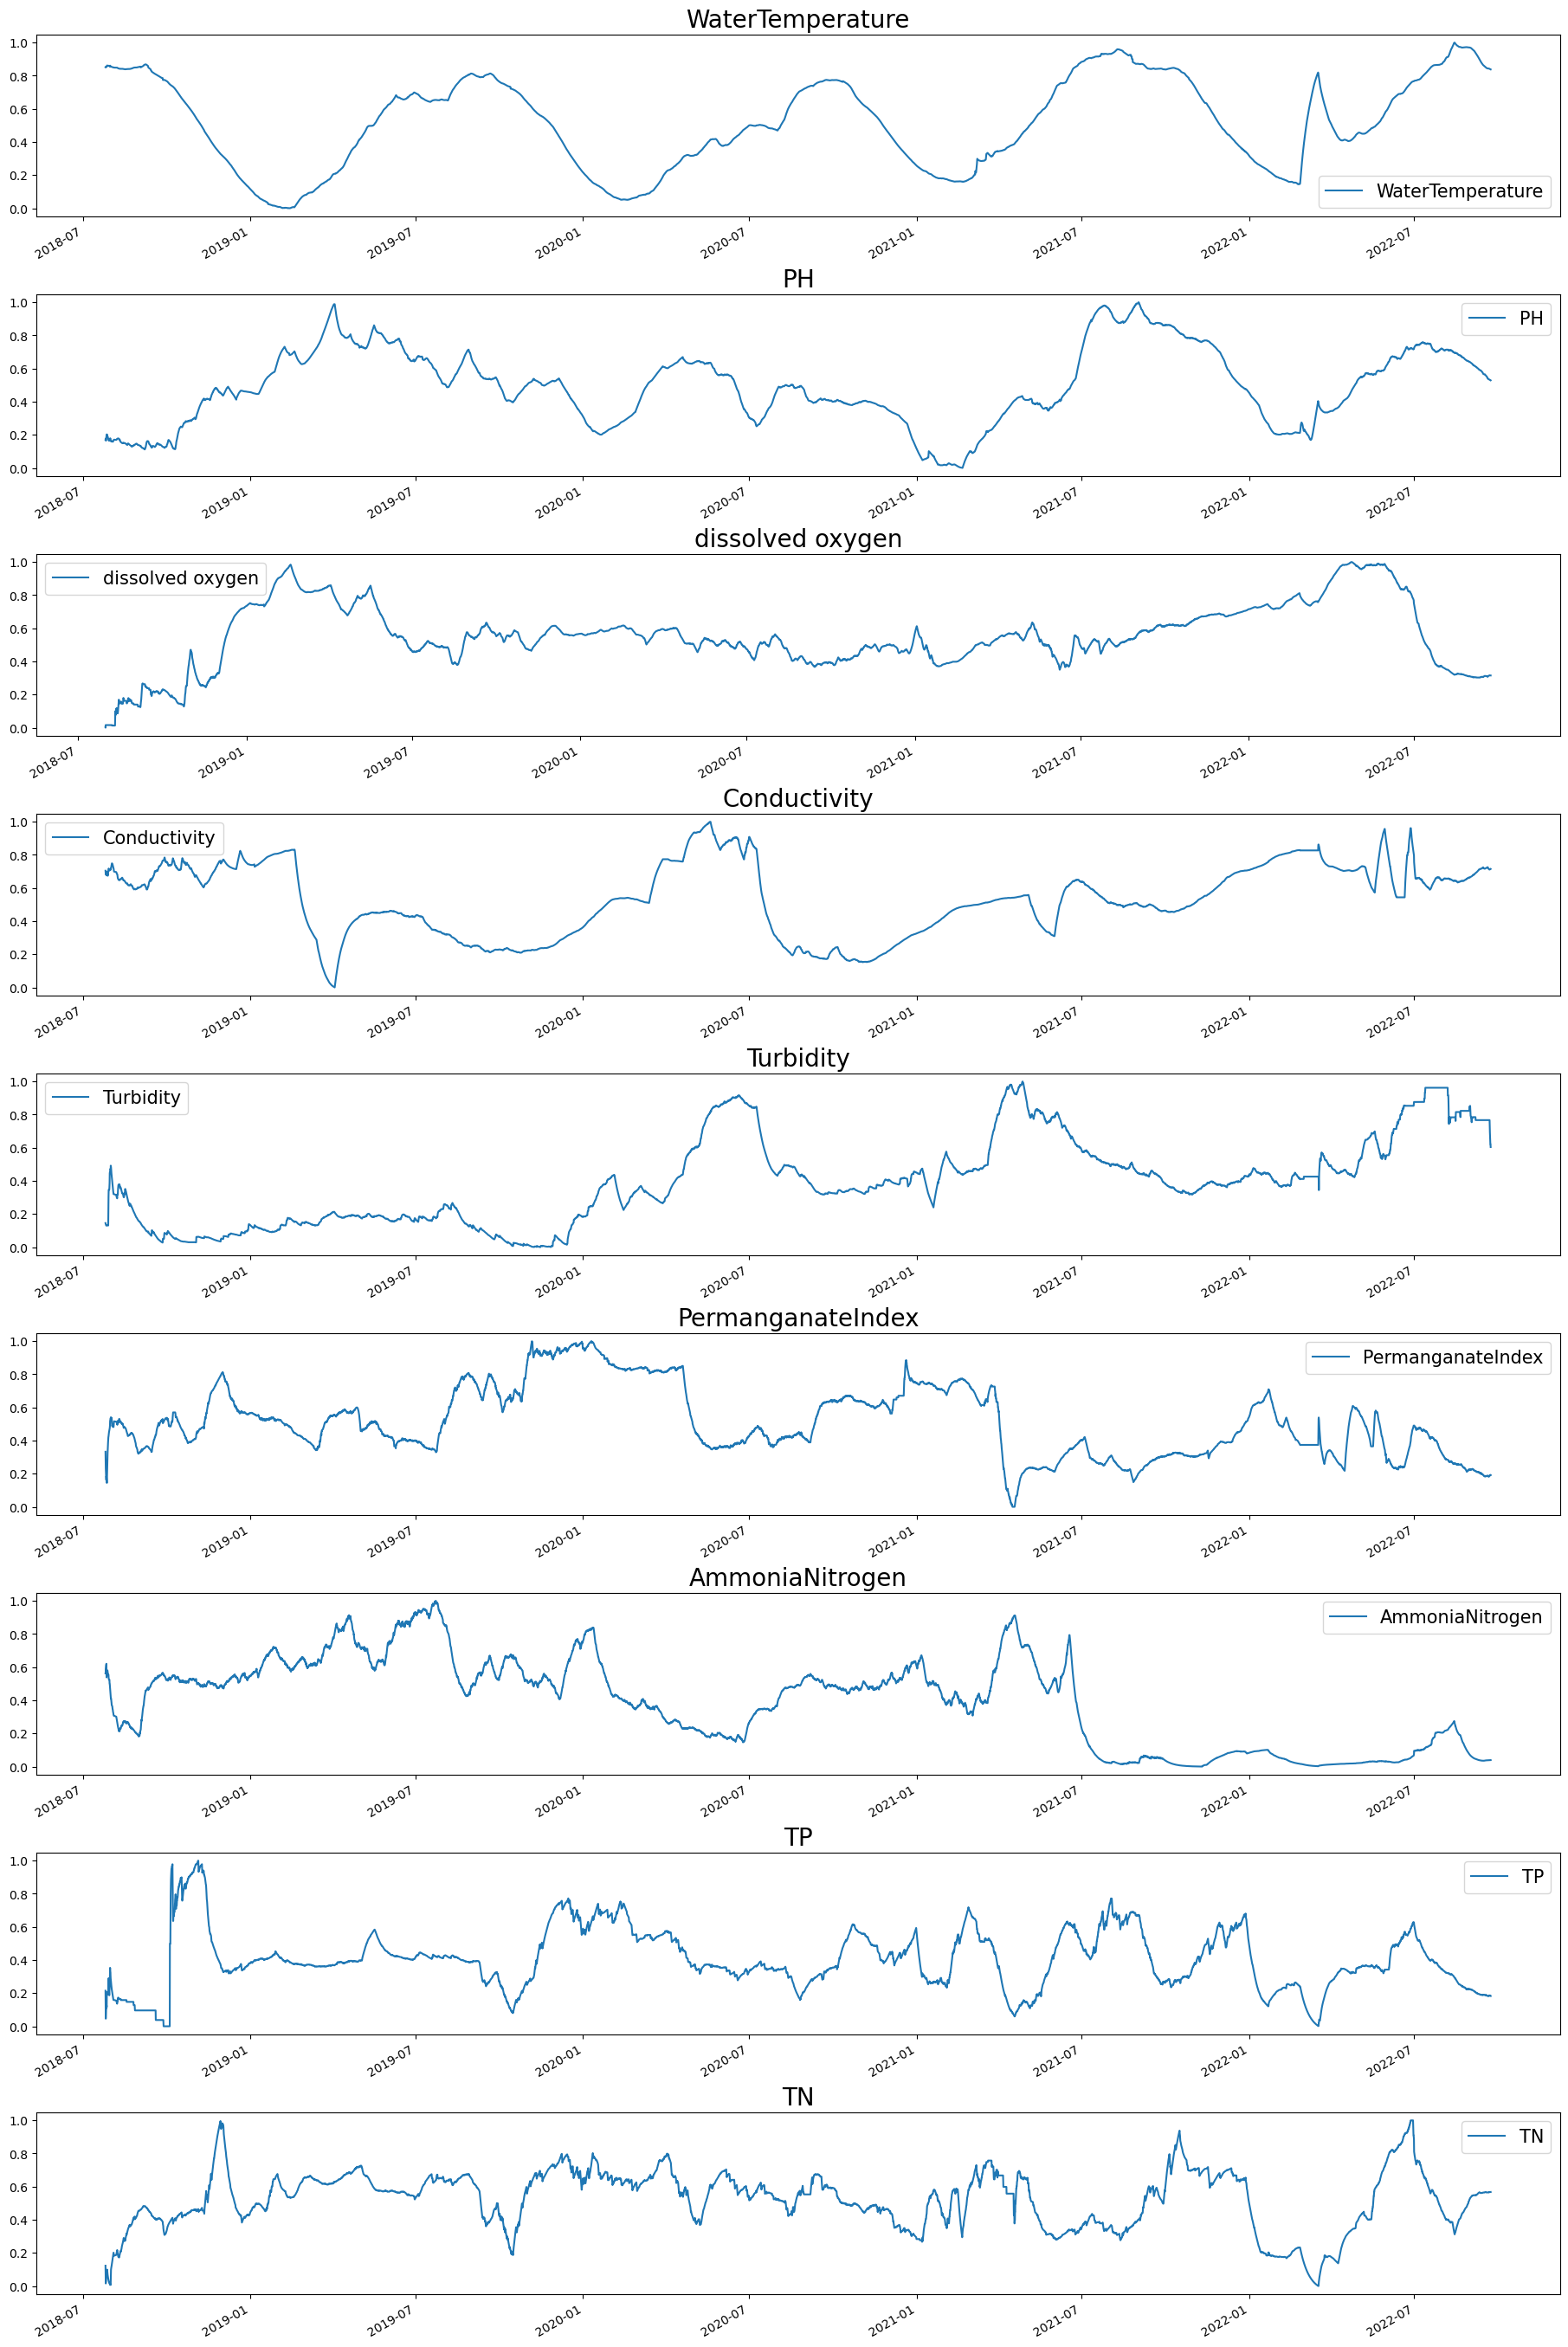

In [54]:
index_nums = len(df.keys())
print(df.keys())
l, h = 18, 3
fig, axis = plt.subplots(index_nums, 1, figsize=(l, h*index_nums), constrained_layout=True)
for i in range(index_nums):
    name = en_keys[i]
    df.plot(y=df.keys()[i], ax=axis[i])
    axis[i].set_title(name, fontsize=20)
    axis[i].set_xlabel('', fontsize=15)
    axis[i].set_ylabel('', fontsize=15)
    
    axis[i].legend([name], fontsize=15)

浊度, 8914
[2.20e+00 2.17e+00 2.15e+00 ... 5.53e+00 5.52e+00 5.40e+00]


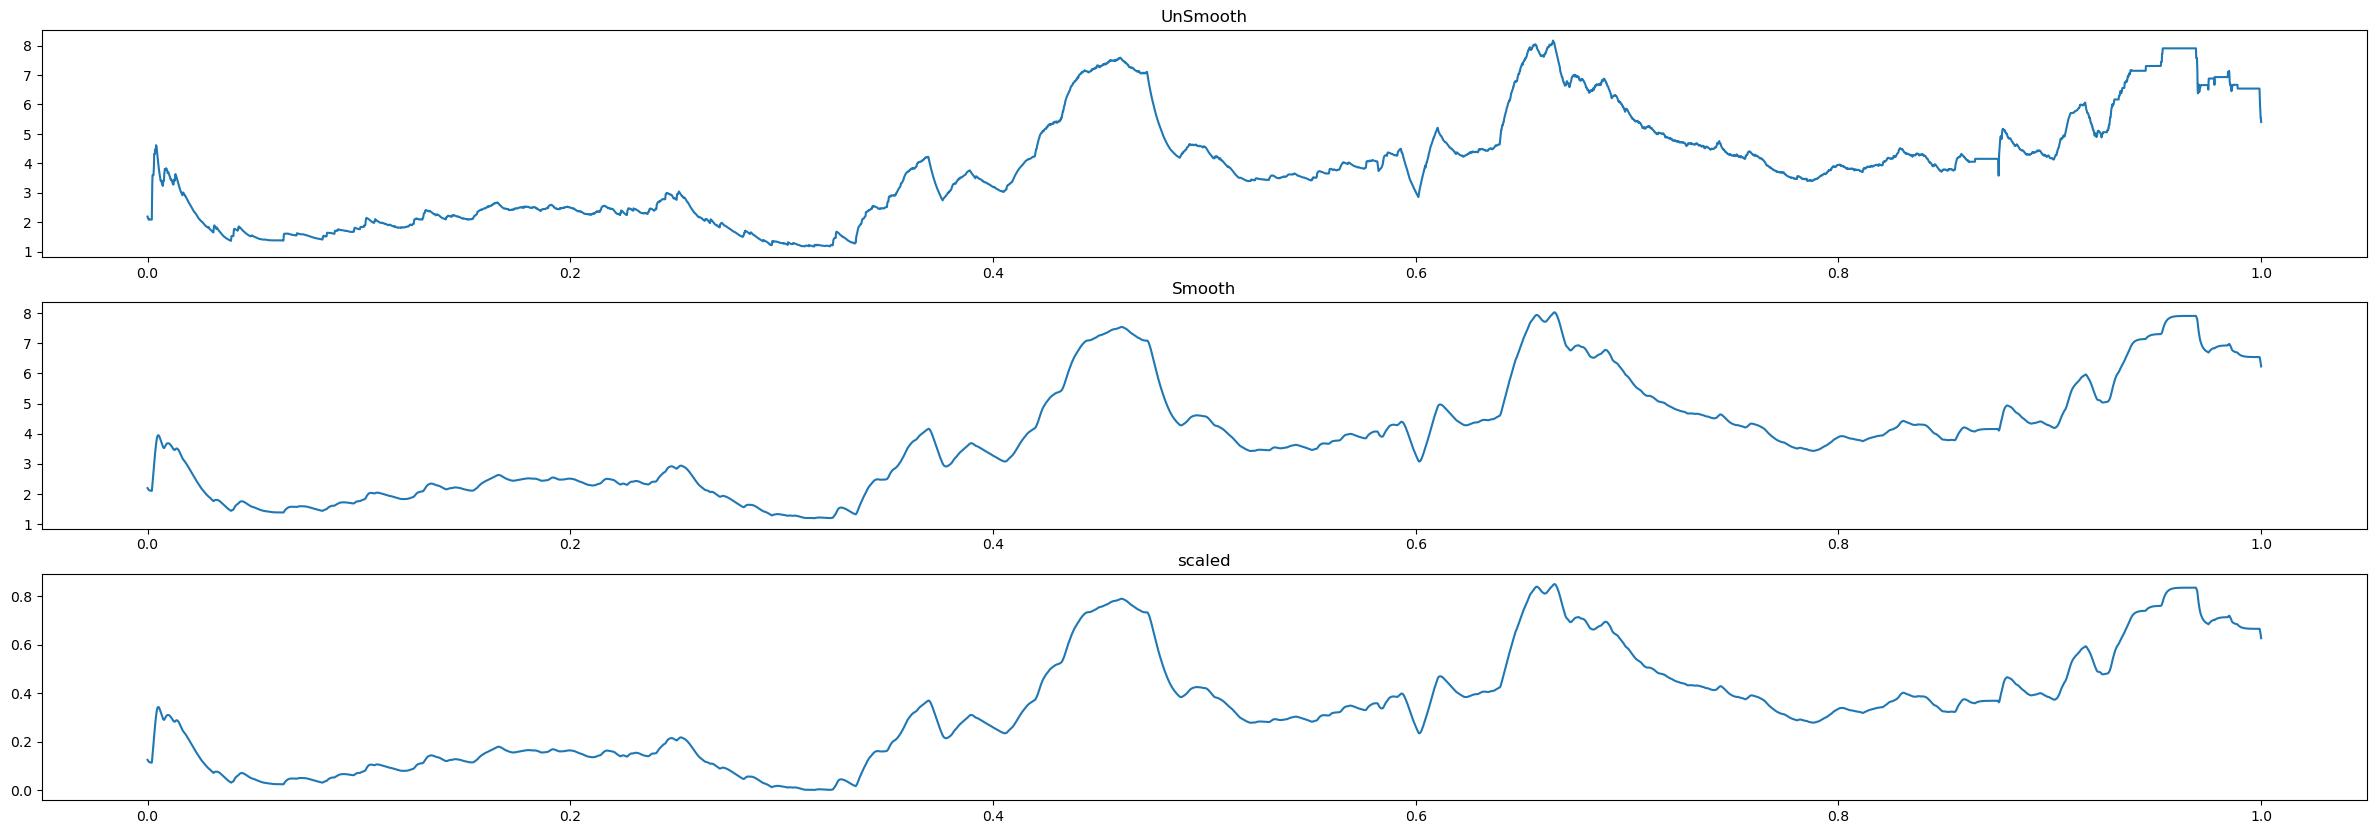

In [48]:
figure, axis = plt.subplots(3, 1, figsize=(30, 10))
name = keys[5]
vals = df[name].values.copy()
print(f'{name}, {len(vals)}')
print(vals)
X = np.linspace(0, 1, len(vals))
axis[0].plot(X, vals)
axis[0].set_title('UnSmooth')
smooth_vals = pd.Series(vals).ewm(span=30).mean()
axis[1].plot(X, smooth_vals)
axis[1].set_title('Smooth')
scaled_vals = (smooth_vals - smooth_vals.min()) / smooth_vals.max()
axis[2].plot(X, scaled_vals)
axis[2].set_title('scaled')


plt.show()